# Classifier Evaluation Example 1

In this example we evaluate the multi-class classifier we created in Training Example 1.  
We will use the same approach to create and read the data.  However, the data file used
for evaluation will be newly generated, guaranteeing that we are not using any data
used in the training.

As a reminder: the function `truth_labels_unit_circle` in the `dataprovider` module 
defines three classes for the (x1, x2) tuples:

 1. points outside the unit circle `r = sqrt(x1*x1 + x2*x2) >= 1` (this is considered 'background')
 2. points in the unit circle with `x2 <= 0.0` (this is considered 'signal 1')
 3. points in the unit circle with `x2 > 0.0` (this is considered 'signal 2')
 
The truth labels are therefore one-hot vectors of dimension 3.  The `dataprovider` 
dynamically generates the truth labels using the above definition. 

#### Setup
Import the required modules and make sure our (and only our!) modules are reloaded 
before code execution.

In [1]:
%reload_ext autoreload
%aimport dataprovider, classification
%autoreload 1

# framework modules
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# our modules
import dataprovider as dp
import classification as cl

#### Data Sets
Here we generate a binary file with a data set for evaluation and provide the corresponding 
PyTorch data set.

In [3]:
data_file_path = './evaluation_data.bin'
dp.generate_data(data_file_path, force=False)
num_events = 20000
evaluation_events = dp.events(data_file_path, evt_max=num_events)
evaluation_dataset = cl.LabeledDataset(evaluation_events,
                                     var_generator=dp.event_to_values,
                                     label_generator=dp.truth_labels_unit_circle)
xs, ys_true = evaluation_dataset[:]

The file './evaluation_data.bin' already exists, no data generated. Use force=True to regenerate.


#### Run the Trained Classifier

We construct the classifier and load the weights produced in Training Example 1.
Next we run the classifier on the entire dataset. Not that we do this with auto 
gradient following turned off.  This is faster and we do not need the gradient
tree for inference.

In [7]:
classifier_nn = cl.ClassifierNN(layout=(2, 5, 7, 3))
weight_file_path = 'classifier_weights_example1_2x5x7x3.pt'
classifier_nn.load_state_dict(torch.load(weight_file_path))
classifier_nn.eval()
with torch.no_grad():
    ys_pred = classifier_nn(xs)
    
print('Classfified', ys_pred.size()[0], 'events into', ys_pred.size()[1], 'classes.')
    

Classfified 20000 events into 3 classes.


#### ROC Curves
ROC (Receiver Operating Characteristic) curves are the ML community's version
of the background suppression versus efficiency plots we are used to in HEP.
In fact they are almost exactly the same.

In a ROC curve the the *true positive rate* if plotted versus the *false positive rate*.

The *true positive rate* is the fraction of true target class instances identified as such, ie. 
the *efficiency*.

The *false positive rate* is the fraction of true background events identified as such, ie.
 *1 - background suppression*.

The rates are computed by scanning the classifier output 
in the interval `[0, 1]`. We do not have to write the code for this 
scan ourselves.  Instead we use the `metric` facilities of `sklearn`.

AUC is simply the area under the ROC curve in the interval `[0, 1]`. 
An AUC of 1 is ideal.

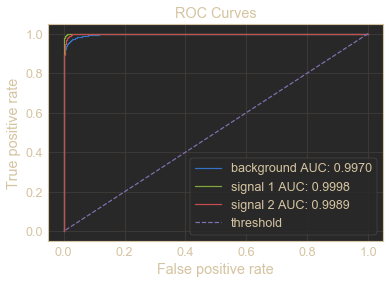

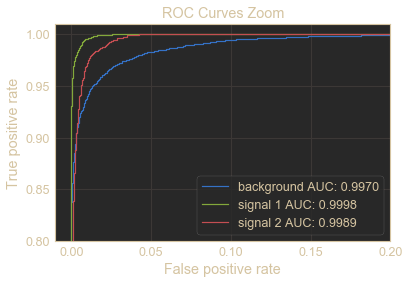

In [8]:
plot_labels = {0 : 'background', 1 : 'signal 1', 2: 'signal 2'}
fpr, tpr, thresh, area = dict(), dict(), dict(), dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(ys_true[:,i], ys_pred[:,i])
    area[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.title('ROC Curves')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='{} AUC: {:.4f}'.format(plot_labels[i], area[i]))

plt.plot(thresh[2][1:], thresh[2][1:], '--', label='threshold')
plt.legend()
plt.show()

plt.figure()
plt.title('ROC Curves Zoom')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim((-0.01, 0.2))
plt.ylim((0.8, 1.01))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='{} AUC: {:.4f}'.format(plot_labels[i], area[i]))
plt.legend()
plt.show()

#### Background Suppression Versus Efficiency

We now plot the same data in the more familiar 
fashion of background suppression versus efficiency.

Here (and in the ROC section above) the *background* is the collection of events that
are a different class instance than the class label considered. For example, the background for 
*signal 1* is all events where the true class is either *background* or *signal 2*.

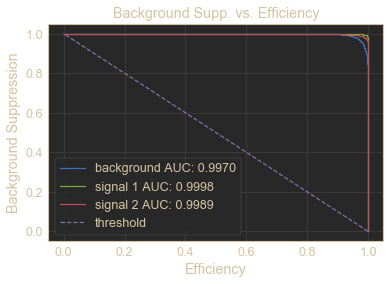

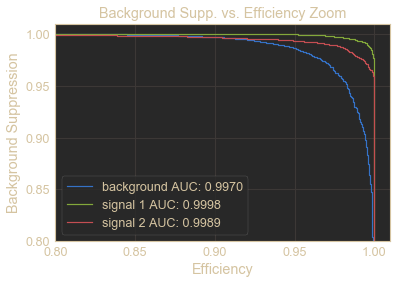

In [9]:
eff = tpr

plt.figure()
plt.title('Background Supp. vs. Efficiency')
plt.xlabel('Efficiency')
plt.ylabel('Background Suppression')
for i in range(3):
    plt.plot(eff[i], 1.0 - fpr[i], label='{} AUC: {:.4f}'.format(plot_labels[i], area[i]))
plt.plot(thresh[2][1:], 1.0 - thresh[2][1:], '--', label='threshold')
plt.legend()
plt.show()

plt.figure()
plt.title('Background Supp. vs. Efficiency Zoom')
plt.xlabel('Efficiency')
plt.ylabel('Background Suppression')
plt.xlim((0.8, 1.01))
plt.ylim((0.8, 1.01))
for i in range(3):
    plt.plot(eff[i], 1.0 - fpr[i], label='{} AUC: {:.4f}'.format(plot_labels[i], area[i]))
plt.legend()
plt.show()
